In [ ]:
%pip install torch torchvision


In [ ]:
%pip install torch-lr-finder


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [36]:
import torch #for using tensors and any computations
import torch.nn as nn # used to build neural networks (layers, loss functions)
import torch.optim as optim #optim algos
from torch.utils.data import DataLoader#loads data in batches and shuffles them
from dataset import ClipDataset #custom dataset class for loading in the ds to the model
from model import build_model_r3d_18 #function that defines the model
from model import build_model_mc3
from torch_lr_finder import LRFinder #finds a good lr to use for model updates
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import os

In [5]:
# Set Device -> Load data -> Build Model -> pick loss/optimizer -> Train Loop -> Evaluate -> Save

In [6]:
#Setting the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Example Training Loop Explanation
# outputs = model(clips)               # model makes guesses
# loss = criterion(outputs, labels)    # "someone" tells how wrong the guesses were
# loss.backward()                      # model feels the pain and learns
# optimizer.step()                     # weights are updated based on the feedback

# The loss function is like your teacher saying:
#    "You got 5 out of 8 wrong — here's how wrong you were and how much to adjust."

In [ ]:
#Load previous model if it exists
force_retrain = True
model = build_model_r3d_18()
model = model.to(device)
model_name = "r3d_18"
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_path = f"checkpoints/{model_name}.pth"

start_epoch = 0
best_val_acc = 0.0
if os.path.exists(model_path) and not force_retrain:
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict']) # the weights of the model
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #for when you want to restore memory from the saved optimizer (ie, LR Scheduling and gradient history)
    best_val_acc = checkpoint['val_acc'] #this is the saved accuracy
    start_epoch = checkpoint['epoch'] #resumes from the last epoch saved
    print(f"Loaded the previous checkpoint at epoch {start_epoch} with accuracy {best_val_acc: .2f}")
else:
    print("No Checkpoint found. Starting Training from scratch")

# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'val_acc': best_val_acc
# }, model_path)


No Checkpoint found. Starting Training from scratch


In [9]:
# Define and Load Dataset

seed = 42

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)


train_dataset = ClipDataset(csv_path="/home/atupulazi/personal_projects/collision-detection/frames/train/train_clip_labels.csv", split='train')
val_dataset = ClipDataset(csv_path="/home/atupulazi/personal_projects/collision-detection/frames/val/val_clip_labels.csv", split='val')

# batch_size is how many samples are passed into the model before the weights are updated
    # You look at 8 clips at once, guess all of them, then someone (training loss) tells you how many you got right. 
    # You adjust your understanding based on all 8 at once
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [10]:
# Build Model

#model = build_model_mc3()
model = model.to(device) # builds the model on the GPU if available or CPU if not
#model_name = "mc3_18"




In [11]:
# Pick Loss and Optimizer

criterion = nn.CrossEntropyLoss()
# model.parameters() are numbers the model can change to improve its performance. Pytorch does this automatically


 84%|████████▍ | 84/100 [00:06<00:01, 13.52it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.75E-01


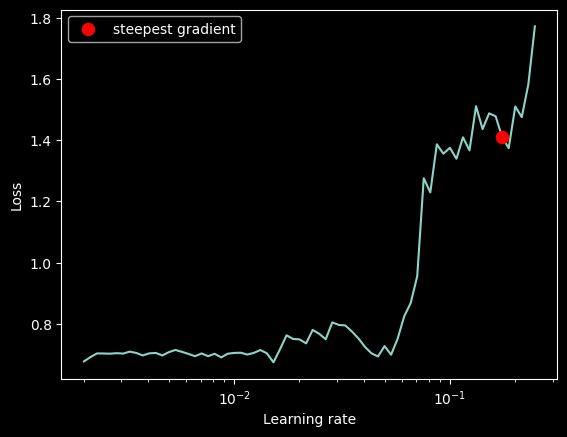

In [12]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)  # Try LRs from 1e-7 to 1

# Plot the result
lr_finder.plot()  # This shows you the graph
lr_finder.reset() # Reset model & optimizer to initial state

In [20]:
# Training Loop (Evaluate)

num_of_epochs = 10 # More epochs = more chances to learn from the same data.\
train_losses = []
val_accuracy = []



for epoch in range(start_epoch, num_of_epochs):
    #save all the preds/labels for each batch
    all_preds = []
    all_labels = []
    # why? do u need this? exp what exactly it does
    model.train() #  puts layers like dropout/batchnorm in training mode.
    running_loss = 0.0 # Tracks cumulative loss for this epoch.

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad() # reset previous gradients? why?
        outputs = model(clips) # Forward pass? meaning?
        loss = criterion(outputs, labels) # Compute Loss
        loss.backward() # backward pass (compute gradients). is this backprop? 
        optimizer.step() # update weights. how does this update weights? i thought weights updates going forward not backward

        running_loss = running_loss + loss.item() #accumulate loss. what is item? why do we want to accumulate loss?

    avg_loss = running_loss / len(train_loader) # Why are we dividing by the len of train_loader and not by the num of epochs
    train_losses.append(avg_loss)
    print(f"[Epoch: {epoch+1}] Train Loss: {avg_loss:.4f}") #why are we doing +1?

    # Validation Loop
    
    model.eval() # turns off dropout, batchnorm updates. what are those and why do we turn them off?
    correct_predictions = 0
    total_seen = 0

    with torch.no_grad():
        for clips, labels in val_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips) #forward only, is there another way for backward? like why do we have to specify this
            _, predicted = torch.max(outputs.data, 1) # only get predicted class. what is torch.max? outputs.data? 1?
            total_seen += labels.size(0) #huh??
            correct_predictions += (predicted == labels).sum().item() # i understand that this is checking if the predicted label 
                                                                   # is the sames as the actual labels but why use .sum and .item

            #collect predictions and labels from every batch (8) not just the last one
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
        accuracy = 100 * correct_predictions / total_seen # get the accuracy result out of a 100?
        print(f"Epoch: {epoch+1} Validation Accuracy: {accuracy: .2f}%")
        val_accuracy.append(accuracy)


        #check if this is the best accuracy
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'val_acc': best_val_acc
            }, model_path)
            print(f"New best model saved with accuracy {best_val_acc:.2f}%")
        
    


    

[Epoch: 1] Train Loss: 0.4436
Epoch: 1 Validation Accuracy:  76.00%
[Epoch: 2] Train Loss: 0.4079
Epoch: 2 Validation Accuracy:  74.00%
[Epoch: 3] Train Loss: 0.4349
Epoch: 3 Validation Accuracy:  76.00%
[Epoch: 4] Train Loss: 0.4307
Epoch: 4 Validation Accuracy:  74.00%
[Epoch: 5] Train Loss: 0.3714
Epoch: 5 Validation Accuracy:  75.00%
[Epoch: 6] Train Loss: 0.4113
Epoch: 6 Validation Accuracy:  78.00%
[Epoch: 7] Train Loss: 0.4041
Epoch: 7 Validation Accuracy:  75.00%
[Epoch: 8] Train Loss: 0.3961
Epoch: 8 Validation Accuracy:  77.00%
[Epoch: 9] Train Loss: 0.3832
Epoch: 9 Validation Accuracy:  75.00%
[Epoch: 10] Train Loss: 0.4101
Epoch: 10 Validation Accuracy:  78.00%


In [21]:
# merge all the pred/labels from every batch bc classification expects one flat array
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print(classification_report(
    all_preds.cpu().numpy(),
    all_labels.cpu().numpy(),
    target_names=['no_crash', 'crash']
))
# scikit-learn only accepts NumPy arrays on the CPU.


              precision    recall  f1-score   support

    no_crash       0.86      0.74      0.80        58
       crash       0.70      0.83      0.76        42

    accuracy                           0.78       100
   macro avg       0.78      0.79      0.78       100
weighted avg       0.79      0.78      0.78       100



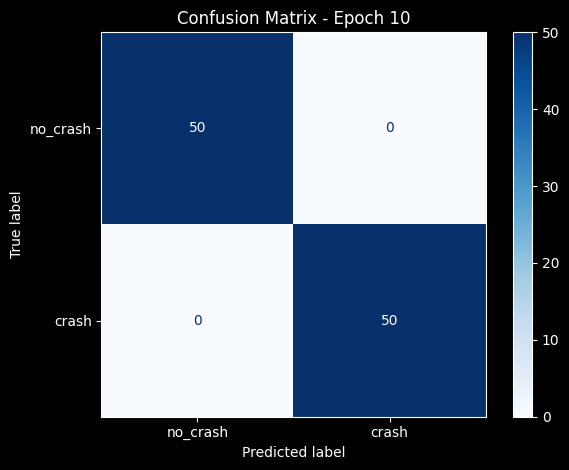

In [30]:
y_true = all_labels.cpu().numpy()
y_pred = all_labels.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no_crash", "crash"])

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Epoch {epoch+1}")
plt.tight_layout()
plt.show()

#--To giver percentages b/w 0 and 1
# y_true = all_labels.cpu().numpy()
# y_pred = all_labels.cpu().numpy()

# cm = confusion_matrix(y_true, y_pred, normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no_crash", "crash"])

# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Epoch {epoch+1}")
# plt.tight_layout()
# plt.show()

In [ ]:
# Save plot with timestamp and model name
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("confusion_matrix", exist_ok=True)

matrix_path = f"confusion_matrix/confusion_matrix_epoch_{epoch+1}_{model_name}_{timestamp}.png"
plt.savefig(matrix_path)
plt.close()
print(f"Confusion matrix saved to {matrix_path}")

#LOG TO CSV
csv_path = f"confusion_matrix/confusion_matrix_{model_name}_{timestamp}.csv"
cm_df = pd.DataFrame(cm, index=['actual_no_crash', 'actual_crash'],
                        columns=['pred_no_crash', 'pred_crash'])
cm_df.to_csv(csv_path)

print(f"Confusion matrix values saved to {csv_path}")


Confusion matrix saved to confusion_matrix/confusion_matrix_epoch_10_r3d_18_20250624_202509.png
Confusion matrix values saved to confusion_matrix/confusion_matrix_r3d_18_20250624_202509.csv


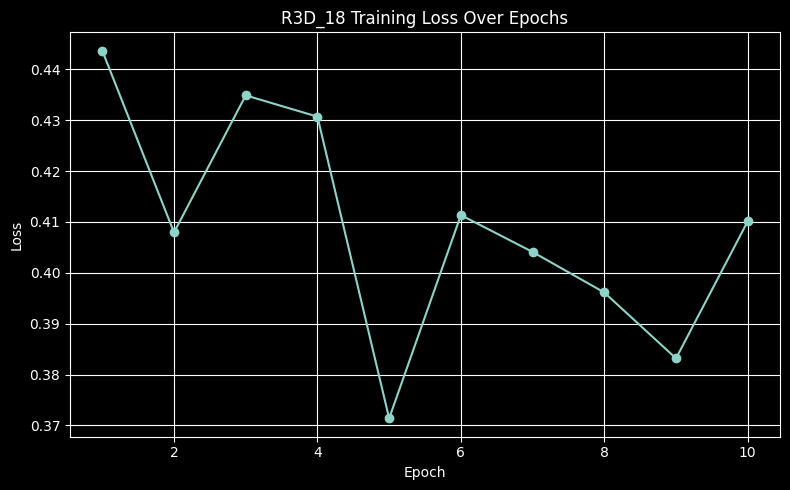

In [22]:
# ========== Plotting ==========

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("plots", exist_ok=True)

# Save plot by model name + timestamp (optional for versioning)
plot_filename = f"plots/{model_name}_loss_plot_{timestamp}.png"

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title(f"{model_name.upper()} Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save plot
plt.savefig(plot_filename)
plt.close()


In [ ]:
#Save the current model

os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), f"checkpoints/{model_name}.pth")

In [39]:
# # Ensure folder exists
# os.makedirs("metrics_log", exist_ok=True)

# # Build clean filename
# filename = f"metrics_log/{model_name}_{timestamp}.csv"

# # Check if file exists so you only write header once
# write_header = not os.path.exists(filename)

# # with open(filename, "a") as f:
# #     if write_header:
# #         f.write("Epoch,Average Loss,Accuracy\n")
# #     f.write(f"{epoch+1},{avg_loss:.4f},{accuracy:.2f}\n")


# # precision, recall, f1, _ = precision_recall_fscore_support(
# #     all_labels.numpy(), all_preds.numpy(), average='weighted'
# # )
# # acc = accuracy_score(all_labels.numpy(), all_preds.numpy())

# # with open(filename, "a") as f:
# #     f.write("\nVal Results:\n")
# #     f.write("Test Accuracy,Precision,Recall,F1,Timestamp\n")
# #     f.write(f"{acc:.4f},{precision:.4f},{recall:.4f},{f1:.4f},{timestamp}\n")

# # print(f"Combined metrics (train + Val) saved to {filename}")

# # Compute test metrics
# precision, recall, f1, _ = precision_recall_fscore_support(
#     all_labels.numpy(), all_preds.numpy(), average='weighted'
# )
# acc = accuracy_score(all_labels.numpy(), all_preds.numpy())

# # Write all in one line
# with open(filename, "w") as f:
#     f.write("Epoch,Average Loss,Validation Accuracy,Test Accuracy,Precision,Recall,F1,Timestamp\n")
#     f.write(f"{epoch},{avg_loss:.4f},{val_accuracy:.2f},{acc:.2f},{precision:.4f},{recall:.4f},{f1:.4f},{timestamp}\n")

# print(f"All metrics logged to: {filename}")

NameError: name 'val_acc' is not defined

In [ ]:
#Early Stopping if accuracy doesnt improve
# best_accuracy = 0
# if accuracy > best_accuracy:
#     best_accuracy = accuracy
#     torch.save(model.state_dict(), "checkpoints/best_model.pth")
#     patience_counter = 0
# else:
#     patience_counter += 1
#     if patience_counter >= patience_limit:
#         print("Early stopping triggered")
#         break
